<a href="https://colab.research.google.com/github/dharace/Fake-News-Detection/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# -*- coding: utf-8 -*-

"""
@author: Dhara & Avi
"""

!pip install -U scikit-learn
!pip install numpy
!pip install scipy
# !pip3 install -U scikit-learn scipy matplotlib

# !pip install sklearn

import warnings
warnings.filterwarnings('ignore')

import sklearn

#import os
import pandas as pd
import csv
import numpy as np
import nltk
import nltk.corpus 
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

from gensim.models.word2vec import Word2Vec
import pickle
import itertools

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
#before reading the files, setup the working directory to point to project repo
#reading data files 

test_filename = '/content/drive/MyDrive/Fake News Detection/test.csv'
train_filename = '/content/drive/MyDrive/Fake News Detection/train.csv'
valid_filename = '/content/drive/MyDrive/Fake News Detection/valid.csv'

train_news = pd.read_csv(train_filename)
test_news = pd.read_csv(test_filename)
valid_news = pd.read_csv(valid_filename)

nltk.download('treebank')
nltk.download('stopwords')


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
train_news.head(5)

,Statement,Label
0,Says the Annies List political group supports ...,False
1,When did the decline of coal start? It started...,True
2,"Hillary Clinton agrees with John McCain ""by vo...",True
3,Health care reform legislation is likely to ma...,False
4,The economic turnaround started at the end of ...,True


In [88]:
test_news.head(5)

,Statement,Label
0,Building a wall on the U.S.-Mexico border will...,True
1,Wisconsin is on pace to double the number of l...,False
2,Says John McCain has done nothing to help the ...,False
3,Suzanne Bonamici supports a plan that will cut...,True
4,When asked by a reporter whether hes at the ce...,False


In [87]:
valid_news.head(5)

,Statement,Label
0,We have less Americans working now than in the...,FALSE
1,"When Obama was sworn into office, he DID NOT u...",FALSE
2,Says Having organizations parading as being so...,FALSE
3,Says nearly half of Oregons children are poor.,TRUE
4,On attacks by Republicans that various program...,TRUE


In [3]:
#data observation
def data_obs():
  print("training dataset size:")
  print(train_news.shape)
  print(train_news.head(10))

#below dataset were used for testing and validation purposes
  print(test_news.shape)
  print(test_news.head(10))
    
  print(valid_news.shape)
  print(valid_news.head(10))

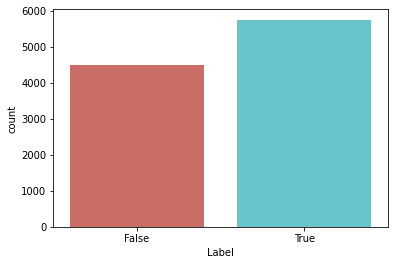

In [90]:
#check the data by calling below function
#data_obs()

#distribution of classes for prediction
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')
    

#by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_news)

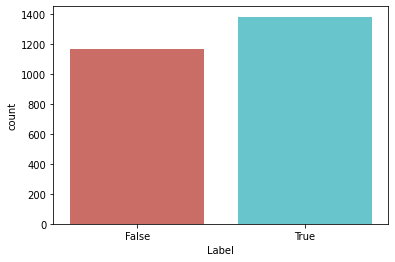

In [91]:
create_distribution(test_news)

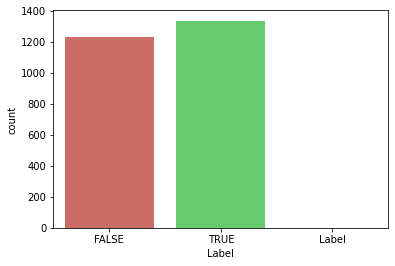

In [92]:
create_distribution(valid_news)

In [93]:
#data integrity check (missing label values)
#none of the datasets contains missing values therefore no cleaning required
def data_qualityCheck():
    
    print("Checking data qualitites...")
    train_news.isnull().sum()
    train_news.info()
        
    print("check finished.")

    #below datasets were used to 
    test_news.isnull().sum()
    test_news.info()

    valid_news.isnull().sum()
    valid_news.info()

#run the below function call to see the quality check results
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  10240 non-null  object
 1   Label      10240 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 90.1+ KB
check finished.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  2551 non-null   object
 1   Label      2551 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 22.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  2571 non-null   object
 1   Label      2569 non-null   object
dtypes: object(2)
memory usage: 40.3+ KB


In [6]:
eng_stemmer = SnowballStemmer('english')
stopwords = set(nltk.corpus.stopwords.words('english'))

#Stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

In [7]:

#process the data
def process_data(data,exclude_stopword=True,stem=True):
    tokens = [w.lower() for w in data]
    tokens_stemmed = tokens
    tokens_stemmed = stem_tokens(tokens, eng_stemmer)
    tokens_stemmed = [w for w in tokens_stemmed if w not in stopwords ]
    return tokens_stemmed


In [8]:
#creating ngrams
#unigram 
def create_unigram(words):
    assert type(words) == list
    return words

#bigram
def create_bigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 1:
        lst = []
        for i in range(Len-1):
            for k in range(1,skip+2):
                if i+k < Len:
                    lst.append(join_str.join([words[i],words[i+k]]))
    else:
        #set it as unigram
        lst = create_unigram(words)
    return lst

#trigrams
def create_trigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 2:
        lst = []
        for i in range(1,skip+2):
            for k1 in range(1, skip+2):
                for k2 in range(1,skip+2):
                  if i+k1 < Len and i+k1+k2 < Len:
                            lst.append(join_str.join([words[i], words[i+k1],words[i+k1+k2]]))
        else:
            #set is as bigram
            lst = create_bigrams(words)
    return lst

In [9]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [11]:
#doc = ['runners like running and thus they run','this is a test for tokens']
#tokenizer([word for line in test_news.iloc[:,1] for word in line.lower().split()])

#show the distribution of labels in the train and test data

def create_datafile(filename):
    #function to slice the dataframe to keep variables necessary to be used for classification
    return "return df to be used"

    
#converting multiclass labels present in our datasets to binary class labels
# for i , row in data_TrainNews.iterrows():
#     if (data_TrainNews.iloc[:,0] == "mostly-true" | data_TrainNews.iloc[:,0] == "half-true" | data_TrainNews.iloc[:,0] == "true"):
#         data_TrainNews.iloc[:,0] = "true"
#     else :
#         data_TrainNews.iloc[:,0] = "false"
        
# for i,row in data_TrainNews.iterrows():
#     print(row)

    


In [12]:
#we will start with simple bag of words technique 
#creating feature vector - document term matrix
countV = CountVectorizer()
train_count = countV.fit_transform(train_news['Statement'].values)

print(countV)
print(train_count)

CountVectorizer()
  (0, 9676)	1
  (0, 10988)	1
  (0, 1044)	1
  (0, 6639)	1
  (0, 8376)	1
  (0, 5115)	1
  (0, 10709)	1
  (0, 11036)	1
  (0, 11296)	1
  (0, 615)	1
  (0, 7728)	1
  (0, 3278)	1
  (1, 10988)	1
  (1, 11934)	2
  (1, 3434)	1
  (1, 3185)	1
  (1, 7672)	1
  (1, 2475)	1
  (1, 10425)	1
  (1, 6052)	1
  (1, 10426)	2
  (1, 7418)	1
  (1, 4860)	1
  (1, 11138)	1
  (1, 7674)	1
  :	:
  (10239, 10988)	1
  (10239, 7672)	2
  (10239, 11110)	2
  (10239, 5267)	1
  (10239, 7828)	1
  (10239, 7824)	1
  (10239, 1159)	1
  (10239, 12151)	2
  (10239, 6327)	1
  (10239, 6603)	1
  (10239, 11013)	1
  (10239, 11004)	1
  (10239, 3309)	1
  (10239, 12158)	1
  (10239, 11660)	2
  (10239, 799)	1
  (10239, 2568)	1
  (10239, 11622)	1
  (10239, 2549)	1
  (10239, 10660)	1
  (10239, 8996)	1
  (10239, 10918)	1
  (10239, 3989)	1
  (10239, 10594)	1
  (10239, 6853)	1


In [13]:
#print training doc term matrix
#we have matrix of size of (10240, 12196) by calling below
def get_countVectorizer_stats():
    
    #vocab size
    train_count.shape

    #check vocabulary using below command
    print(countV.vocabulary_)

    #get feature names
    print(countV.get_feature_names()[:25])


In [14]:
#create tf-df frequency features
#tf-idf 
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

def get_tfidf_stats():
    train_tfidf.shape
    #get train data feature names 
    print(train_tfidf.A[:10])

In [15]:
#bag of words - with n-grams
#countV_ngram = CountVectorizer(ngram_range=(1,3),stop_words='english')
#tfidf_ngram  = TfidfTransformer(use_idf=True,smooth_idf=True)

tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)

#POS Tagging
tagged_sentences = nltk.corpus.treebank.tagged_sents()

cutoff = int(.75 * len(tagged_sentences))
training_sentences = train_news['Statement']
 
print(training_sentences)


0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
                               ...                        
10235    There are a larger number of shark attacks in ...
10236    Democrats have now become the party of the [At...
10237    Says an alternative to Social Security that op...
10238    On lifting the U.S. Cuban embargo and allowing...
10239    The Department of Veterans Affairs has a manua...
Name: Statement, Length: 10240, dtype: object


In [16]:
#training POS tagger based on words
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [17]:
#helper function to strip tags from tagged corpus	
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

In [18]:
#Using Word2Vec

glove_6B_50d = '/content/drive/MyDrive/Fake News Detection/glove.6B.50d.txt'

with open(glove_6B_50d, "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

#model = gensim.models.Word2Vec(X, size=100) # x be tokenized text
#w2v = dict(zip(model.wv.index2word, model.wv.syn0))


In [20]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


# class TfidfEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.word2weight = None
#         self.dim = len(word2vec.itervalues().next())

#     def fit(self, X, y):
#         tfidf = TfidfVectorizer(analyzer=lambda x: x)
#         tfidf.fit(X)
#         # if a word was never seen - it must be at least as infrequent
#         # as any of the known words - so the default idf is the max of 
#         # known idf's
#         max_idf = max(tfidf.idf_)
#         self.word2weight = defaultdict(
#             lambda: max_idf,
#             [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

#         return self

#     def transform(self, X):
#         return np.array([
#                 np.mean([self.word2vec[w] * self.word2weight[w]
#                          for w in words if w in self.word2vec] or
#                         [np.zeros(self.dim)], axis=0)
#                 for words in X
#             ])



In [151]:
#string to test
# doc_new = ['obama is running for president in 2016']

#the feature selection has been done in FeatureSelection.py module. here we will create models using those features for prediction

#first we will use bag of words techniques

#building classifier using naive bayes 
nb_pipeline = Pipeline([
        ('NBCV', countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_nb = nb_pipeline.predict(test_news['Statement'])
np.mean(predicted_nb == test_news['Label'])


0.6072128577028616

In [22]:
#building classifier using logistic regression
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_LogR = logR_pipeline.predict(test_news['Statement'])
np.mean(predicted_LogR == test_news['Label'])

0.6013328106624853

In [23]:
#building Linear SVM classfier
svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_svm = svm_pipeline.predict(test_news['Statement'])
np.mean(predicted_svm == test_news['Label'])


0.5723245785966288

In [24]:
#using SVM Stochastic Gradient Descent on hinge loss
sgd_pipeline = Pipeline([
        ('svm2CV',countV),
        ('svm2_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter =5))
        ])

sgd_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_sgd = sgd_pipeline.predict(test_news['Statement'])
np.mean(predicted_sgd == test_news['Label'])

0.613092904743238

In [25]:
#random forest
random_forest = Pipeline([
        ('rfCV', countV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(train_news['Statement'],train_news['Label'])
predicted_rf = random_forest.predict(test_news['Statement'])
np.mean(predicted_rf == test_news['Label'])

0.6248529988239906

In [120]:
def plot_confusion_matrix(cm, classes, title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.66961153965076
score length 5
Confusion matrix:
[[2118 2370]
 [1664 4088]]


(None, None, None, None, None)

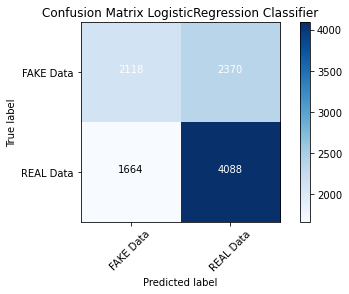

In [121]:
#User defined functon for K-Fold cross validatoin
def build_confusion_matrix(classifier, title):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text = train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y = train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
    
    plot_confusion_matrix(confusion, classes=['FAKE Data', 'REAL Data'], title=title)

    return (print('Total statements classified:', len(train_news)),
    print('Score:', sum(scores)/len(scores)),
    print('score length', len(scores)),
    print('Confusion matrix:'),
    print(confusion))

#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline, "LogisticRegression Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.6466692934443682
score length 5
Confusion matrix:
[[2254 2234]
 [1936 3816]]


(None, None, None, None, None)

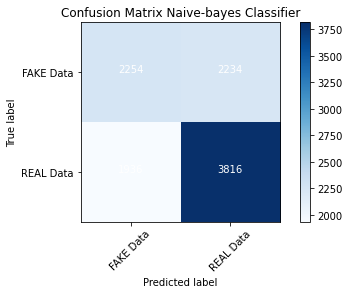

In [122]:
build_confusion_matrix(logR_pipeline, "Naive-bayes Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.6104687487924283
score length 5
Confusion matrix:
[[2260 2228]
 [2246 3506]]


(None, None, None, None, None)

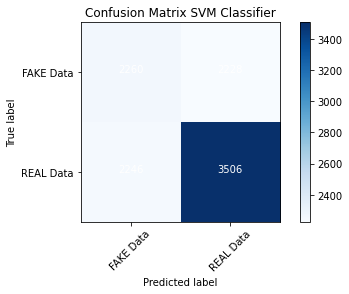

In [123]:
build_confusion_matrix(svm_pipeline, "SVM Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.651678784085379
score length 5
Confusion matrix:
[[2285 2203]
 [1902 3850]]


(None, None, None, None, None)

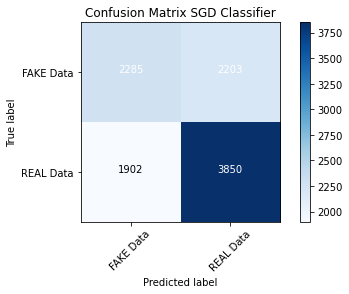

In [124]:
build_confusion_matrix(sgd_pipeline, "SGD Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.7018325140285924
score length 5
Confusion matrix:
[[1799 2689]
 [1188 4564]]


(None, None, None, None, None)

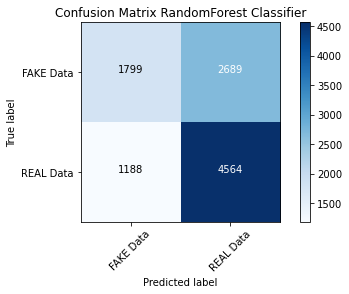

In [125]:
build_confusion_matrix(random_forest, "RandomForest Classifier")

In [28]:
# So far we have used bag of words technique to extract the features and passed those featuers into classifiers. We have also seen the
# f1 scores of these classifiers. now lets enhance these features using term frequency weights with various n-grams

##Now using n-grams

#naive-bayes classifier
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf',tfidf_ngram),
        ('nb_clf',MultinomialNB())])

nb_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_nb_ngram = nb_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_nb_ngram == test_news['Label'])

0.5938847510780086

In [29]:
#logistic regression classifier
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf', tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_ngram.fit(train_news['Statement'], train_news['Label'])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_LogR_ngram == test_news['Label'])

0.6193649549196394

In [30]:
#linear SVM classifier
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])

0.6170129361034888

In [31]:
#sgd classifier
sgd_pipeline_ngram = Pipeline([
         ('sgd_tfidf', tfidf_ngram),
         ('sgd_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5))
         ])

sgd_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_sgd_ngram = sgd_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_sgd_ngram == test_news['Label'])

0.5417483339866719

In [132]:
#random forest classifier
random_forest_ngram = Pipeline([
        ('rf_tfidf', tfidf_ngram),
        ('rf_clf', RandomForestClassifier(n_estimators=100,n_jobs=3))
        ])
    
random_forest_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_rf_ngram = random_forest_ngram.predict(test_news['Statement'])
np.mean(predicted_rf_ngram == test_news['Label'])

0.5950607604860839

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.7224053159841455
score length 5
Confusion matrix:
[[ 758 3730]
 [ 390 5362]]


(None, None, None, None, None)

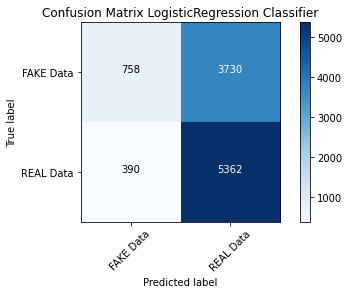

In [126]:
#K-fold cross validation for all classifiers
build_confusion_matrix(nb_pipeline_ngram, "LogisticRegression Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.7044355553757985
score length 5
Confusion matrix:
[[1580 2908]
 [1043 4709]]


(None, None, None, None, None)

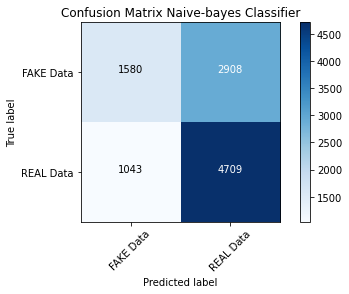

In [127]:
build_confusion_matrix(logR_pipeline_ngram, "Naive-bayes Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.6790920142902143
score length 5
Confusion matrix:
[[2016 2472]
 [1524 4228]]


(None, None, None, None, None)

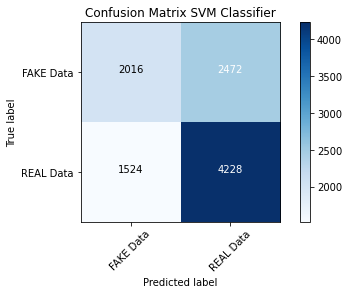

In [128]:
build_confusion_matrix(svm_pipeline_ngram, "SVM Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.7189507895040017
score length 5
Confusion matrix:
[[   6 4482]
 [   8 5744]]


(None, None, None, None, None)

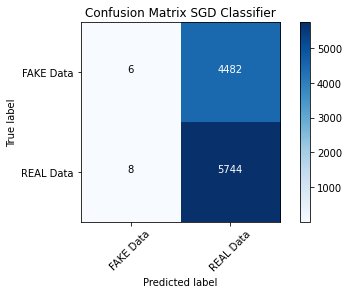

In [129]:
build_confusion_matrix(sgd_pipeline_ngram, "SGD Classifier")

Confusion matrix, without normalization
Total statements classified: 10240
Score: 0.6580293913459252
score length 5
Confusion matrix:
[[2075 2413]
 [1748 4004]]


(None, None, None, None, None)

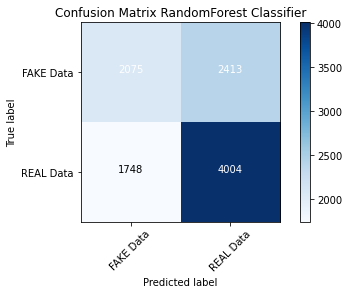

In [133]:
build_confusion_matrix(random_forest_ngram,"RandomForest Classifier")

In [34]:
print(classification_report(test_news['Label'], predicted_nb_ngram))
print(classification_report(test_news['Label'], predicted_LogR_ngram))
print(classification_report(test_news['Label'], predicted_svm_ngram))
print(classification_report(test_news['Label'], predicted_sgd_ngram))
print(classification_report(test_news['Label'], predicted_rf_ngram))

              precision    recall  f1-score   support

       False       0.72      0.19      0.30      1169
        True       0.58      0.94      0.71      1382

    accuracy                           0.59      2551
   macro avg       0.65      0.56      0.51      2551
weighted avg       0.64      0.59      0.52      2551

              precision    recall  f1-score   support

       False       0.64      0.39      0.49      1169
        True       0.61      0.81      0.70      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.59      2551
weighted avg       0.62      0.62      0.60      2551

              precision    recall  f1-score   support

       False       0.61      0.47      0.53      1169
        True       0.62      0.74      0.68      1382

    accuracy                           0.62      2551
   macro avg       0.61      0.61      0.60      2551
weighted avg       0.62      0.62      0.61      2551

              preci

(2551,)

In [134]:
test_news['Label'].shape

(2551,)

In [35]:
# Out of all the models fitted, we would take 2 best performing model. we would call them candidate models
# from the confusion matrix, we can see that random forest and logistic regression are best performing 
# in terms of precision and recall (take a look into false positive and true negative counts which appeares
# to be low compared to rest of the models)

#grid-search parameter optimization
#random forest classifier parameters
parameters = {'rf_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'rf_tfidf__use_idf': (True, False),
               'rf_clf__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15)
}

gs_clf = GridSearchCV(random_forest_ngram, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

gs_clf.best_score_
gs_clf.best_params_
gs_clf.cv_results_

{'mean_fit_time': array([1.35341411, 1.35670123, 1.73168197, 1.73351936, 2.1954494 ,
        2.17326493, 2.5852612 , 2.51669388, 2.869415  , 2.85856647,
        1.32522864, 1.34679351, 1.76929402, 1.70625367, 2.18777838,
        2.14717364, 2.64405093, 2.59795294, 2.9805305 , 2.9334064 ,
        1.41815524, 1.40503922, 1.82919207, 1.84295506, 2.35654588,
        2.2863214 , 2.7668107 , 2.74230552, 3.11765194, 3.07496619,
        1.44043493, 1.4637969 , 1.94373722, 1.90905914, 2.40153894,
        2.37317858, 2.9176867 , 2.81771922, 3.28650274, 3.29939089,
        1.53033123, 1.50036249, 2.01142178, 2.04550257, 2.543852  ,
        2.49901743, 3.05811725, 2.9695672 , 3.60006208, 3.55694475,
        1.63067999, 1.62742434, 2.19762177, 2.18935928, 2.85451608,
        2.91207914, 3.27265768, 3.26419201, 3.78308792, 3.65543919,
        1.6660337 , 1.61830897, 2.30098877, 2.27659106, 2.83408575,
        2.77455959, 3.39089336, 3.41617513, 3.9877152 , 3.88330359,
        1.76269989, 1.73392262,

In [36]:
#logistic regression parameters
parameters = {'LogR_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'LogR_tfidf__use_idf': (True, False),
               'LogR_tfidf__smooth_idf': (True, False)
}

gs_clf = GridSearchCV(logR_pipeline_ngram, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

gs_clf.best_score_
gs_clf.best_params_
gs_clf.cv_results_

{'mean_fit_time': array([0.58099504, 0.46636887, 0.52699327, 0.46562448, 1.61353593,
        1.60461793, 1.41281648, 1.53353162, 2.32736697, 2.80810914,
        2.19768724, 3.07182708, 2.8215971 , 3.62672586, 2.90466123,
        3.68350601, 3.55734434, 4.24300127, 3.83555145, 4.11226916]),
 'mean_score_time': array([0.06485295, 0.06630349, 0.06616993, 0.05885787, 0.09684787,
        0.09310012, 0.09080038, 0.07977266, 0.10599847, 0.10626807,
        0.12013326, 0.12446671, 0.14367671, 0.13585663, 0.14151917,
        0.13660946, 0.15523596, 0.1525661 , 0.1665082 , 0.14235449]),
 'mean_test_score': array([0.6046, 0.6106, 0.6055, 0.6106, 0.6142, 0.6105, 0.614 , 0.6105,
        0.6149, 0.6103, 0.6162, 0.6103, 0.6165, 0.6097, 0.6159, 0.6097,
        0.616 , 0.6093, 0.6151, 0.6093]),
 'param_LogR_tfidf__ngram_range': masked_array(data=[(1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 2), (1, 2),
                    (1, 2), (1, 3), (1, 3), (1, 3), (1, 3), (1, 4), (1, 4),
                    (1, 4)

In [37]:
#Linear SVM 
parameters = {'svm_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'svm_tfidf__use_idf': (True, False),
               'svm_tfidf__smooth_idf': (True, False),
               'svm_clf__penalty': ('l1','l2'),
}

gs_clf = GridSearchCV(svm_pipeline_ngram, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_news['Statement'][:10000],train_news['Label'][:10000])

gs_clf.best_score_
gs_clf.best_params_
gs_clf.cv_results_

{'mean_fit_time': array([0.28318434, 0.2662612 , 0.27289934, 0.27133632, 0.65712719,
        0.62034287, 0.6185421 , 0.60626607, 1.0299654 , 0.97260461,
        0.97769175, 0.96122794, 1.34882684, 1.30672522, 1.35317459,
        1.3019177 , 1.66237035, 1.64870324, 1.68859882, 1.64642706,
        0.28869953, 0.31366343, 0.30937014, 0.30289822, 0.69800644,
        0.68391628, 0.68316917, 0.66485844, 1.09973516, 1.0497417 ,
        1.09400077, 1.067698  , 1.45284719, 1.42037568, 1.45315537,
        1.42755618, 1.83378396, 1.76006112, 1.81678433, 1.72318721]),
 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05504165, 0.05882716, 0.06040192, 0.05770478, 0.09031086,
        0.08962898, 0.08872943, 0.0867312 , 0.11210966, 0.11583915,
        0.

In [38]:
#by running above commands we can find the model with best performing parameters

#running both random forest and logistic regression models again with best parameter found with GridSearch method
random_forest_final = Pipeline([
        ('rf_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3,max_depth=10))
        ])
    
random_forest_final.fit(train_news['Statement'],train_news['Label'])
predicted_rf_final = random_forest_final.predict(test_news['Statement'])
np.mean(predicted_rf_final == test_news['Label'])
print(classification_report(test_news['Label'], predicted_rf_final))


              precision    recall  f1-score   support

       False       0.67      0.00      0.01      1169
        True       0.54      1.00      0.70      1382

    accuracy                           0.54      2551
   macro avg       0.60      0.50      0.35      2551
weighted avg       0.60      0.54      0.38      2551



In [39]:
logR_pipeline_final = Pipeline([
        #('LogRCV',countV_ngram),
        ('LogR_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=False)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_final.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_final = logR_pipeline_final.predict(test_news['Statement'])
np.mean(predicted_LogR_final == test_news['Label'])
#accuracy = 0.62
print(classification_report(test_news['Label'], predicted_LogR_final))

              precision    recall  f1-score   support

       False       0.64      0.38      0.48      1169
        True       0.61      0.82      0.70      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.59      2551
weighted avg       0.62      0.62      0.60      2551



In [40]:
# by running both random forest and logistic regression with GridSearch's best parameter estimation, we found that for random 
# forest model with n-gram has better accuracty than with the parameter estimated. The logistic regression model with best parameter 
# has almost similar performance as n-gram model so logistic regression will be out choice of model for prediction.

#saving best model to the disk
model_file = '/content/drive/MyDrive/Fake News Detection/final_model.sav'
pickle.dump(logR_pipeline_ngram,open(model_file,'wb'))

No handles with labels found to put in legend.


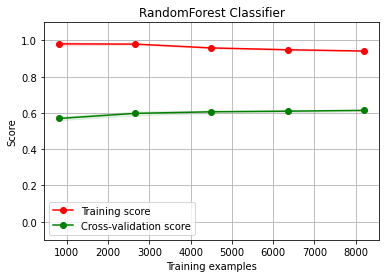

No handles with labels found to put in legend.


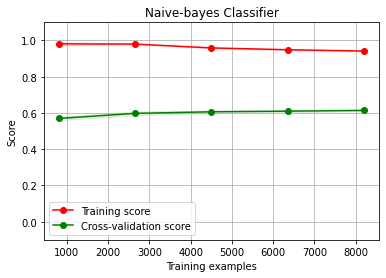

No handles with labels found to put in legend.


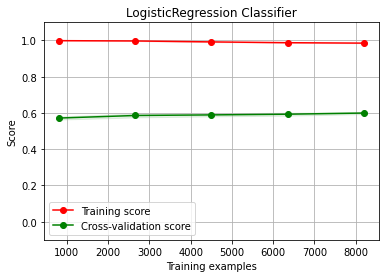

No handles with labels found to put in legend.


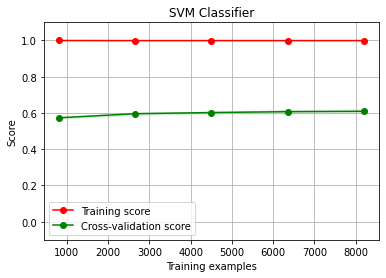

No handles with labels found to put in legend.


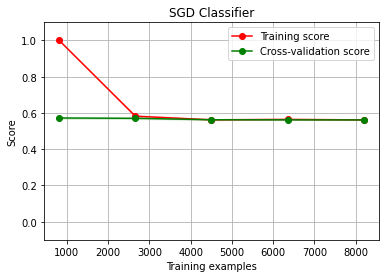

In [79]:
from sklearn.datasets import load_digits

#Plotting learing curve
def plot_learing_curve(pipeline,title):
    
    X = train_news["Statement"]
    y = train_news["Label"]
    
    pl = pipeline
    pl.fit(X,y)

    cv=None
    n_jobs=None
    train_sizes=np.linspace(0.1, 1.0, 5)

    train_sizes, train_scores, test_scores = learning_curve(
        pl,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        # return_times=True,
    )
    
    # train_sizes, train_scores, test_scores = learning_curve(pl, X, y, n_jobs=n_jobs, cv=cv, train_sizes=np.linspace(0.1, 1.0, 5))
       
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best", title_fontsize = 12)

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

#below command will plot learing curves for each of the classifiers
plot_learing_curve(random_forest_ngram,"RandomForest Classifier")
plot_learing_curve(logR_pipeline_ngram,"Naive-bayes Classifier")
plot_learing_curve(nb_pipeline_ngram,"LogisticRegression Classifier")
plot_learing_curve(svm_pipeline_ngram,"SVM Classifier")
plot_learing_curve(sgd_pipeline_ngram,"SGD Classifier")

In [135]:
# by plotting the learning cureve for logistic regression, it can be seen that cross-validation score is stagnating throughout and it 
# is unable to learn from data. Also we see that there are high errors that indicates model is simple and we may want to increase the
# model complexity.


#plotting Precision-Recall curve
def plot_PR_curve(classifier):
    
    precision, recall, thresholds = precision_recall_curve(test_news['Label'], classifier)
    average_precision = average_precision_score(test_news['Label'], classifier)
    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Random Forest Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    

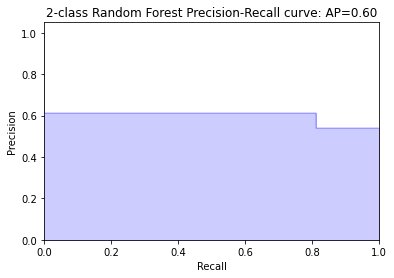

In [136]:
plot_PR_curve(predicted_LogR_ngram)

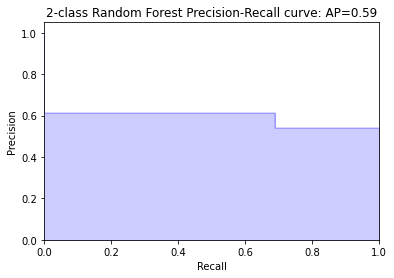

In [137]:
plot_PR_curve(predicted_rf_ngram)

In [138]:
# Now let's extract the most informative feature from ifidf vectorizer for all fo the classifiers and see of there are any common
# words that we can identify i.e. are these most informative feature acorss the classifiers are same? we will create a function that 
# will extract top 50 features.

def show_most_informative_features(model, vect, clf, text=None, n=50):
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps[vect]
    classifier = model.named_steps[clf]

     # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {}.".format(
                classifier.__class__.__name__
            )
        )
            
    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        reverse=True
    )
    
    # Get the top n and bottom n coef, name pairs
    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append(
            "Classified as: {}".format(model.predict([text]))
        )
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(
                cp, fnp, cn, fnn
            )
        )
    #return "\n\n".join(output)
    print(output)

show_most_informative_features(logR_pipeline_ngram,vect='LogR_tfidf',clf='LogR_clf')
show_most_informative_features(nb_pipeline_ngram,vect='nb_tfidf',clf='nb_clf')
show_most_informative_features(svm_pipeline_ngram,vect='svm_tfidf',clf='svm_clf')
show_most_informative_features(sgd_pipeline_ngram,vect='sgd_tfidf',clf='sgd_clf')

['2.8908        percent    -1.7942      obamacare', '1.7637        average    -1.6300           says', '1.6477          times    -1.4106          obama', '1.5998            day    -1.3994           plan', '1.4585        million    -1.2839            rep', '1.4521        georgia    -1.2085      wisconsin', '1.4321      countries    -1.1150           care', '1.4306           debt    -1.0474   scott walker', '1.4227        country    -1.0360         walker', '1.3848        highest    -1.0130       increase', '1.3639       american    -0.9904       medicare', '1.3051           half    -0.9826        clinton', '1.2677            000    -0.9775          scott', '1.1009         states    -0.9539     government', '1.0707         months    -0.9498          going', '0.9916         lowest    -0.9253         obamas', '0.9890             10    -0.9121           away', '0.9856       actually    -0.8947      president', '0.9699         nearly    -0.8871          group', '0.9656          years    -0.8

In [157]:
final_model = '/content/drive/MyDrive/Fake News Detection/final_model.sav'

from sklearn.linear_model import LogisticRegression

#function to run for prediction
def detecting_fake_news(var):    
#retrieving the best model for prediction call
    load_model = pickle.load(open(final_model, 'rb'))
    prediction = load_model.predict([var])
    prob = load_model.predict_proba([var])

    if prediction[0] == 0:
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")

    return print("The truth probability score is ",prob[0][1])

# detecting_fake_news('Says Having organizations parading as being social welfare organizations and then being involved in the political combat harkens back to why the statute a hundred years ago said that they were prohibited.')

In [141]:
#doc_new = ['obama is running for president in 2016']

var = input("Please enter the news text you want to verify: ")
print("You entered: " + str(var))

if __name__ == '__main__':
    detecting_fake_news(var)

Please enter the news text you want to verify: Says nearly half of Oregons children are poor.
You entered: Says nearly half of Oregons children are poor.
The given statement is  True
The truth probability score is  0.6416077159898091


In [155]:
var = input("Please enter the news text you want to verify: ")
print("You entered: " + str(var))

if __name__ == '__main__':
    detecting_fake_news(var)

Please enter the news text you want to verify: Says Having organizations parading as being social welfare organizations and then being involved in the political combat harkens back to why the statute a hundred years ago said that they were prohibited.
You entered: Says Having organizations parading as being social welfare organizations and then being involved in the political combat harkens back to why the statute a hundred years ago said that they were prohibited.
Prediction of the News :  Looking Fake⚠ News📰 
The truth probability score is  0.46344501997729975
